# Extract a section from the NSIDC sea ice clim

#### download from here: https://nsidc.org/data/NSIDC-0192/versions/3

In [108]:
import numpy as np
import matplotlib.pylab as plt

In [109]:
# https://gis.stackexchange.com/questions/97828/reading-zipped-esri-bil-files-with-python
def ReadBilFile(bil):
    import gdal
    gdal.GetDriverByName('EHdr').Register()
    img = gdal.Open(bil)
    band = img.GetRasterBand(1)
    data = band.ReadAsArray()
    return data

#### rename file to "mean.sep.1979-2020.s.bil" , create header file below (https://nsidc.org/support/22256950-How-do-I-import-the-sea-ice-trends-data-into-ArcGIS-)

In [110]:
%%bash

cat > mean.sep.1979-2020.s.hdr <<END
nrows 332

ncols 316

nbands 1

nbits 8

layout bil

byteorder I

ulxmap -3937500

ulymap 4337500

xdim 25000

ydim 25000
END

In [111]:
a = ReadBilFile('mean.sep.1979-2020.s.bil')

In [112]:
# keep the sea ice fraction only
a_masked=np.ma.masked_greater(a, 100., copy=True) 

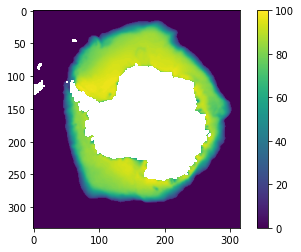

In [113]:
# quick look
plt.imshow(a_masked, vmin=0., vmax=100.)
plt.colorbar()

#### find the indices for a section in the bitmap with NSIDCs python tools

In [114]:
!git clone https://github.com/nsidc/polar_stereo.git

Klone nach 'polar_stereo' ...
remote: Enumerating objects: 139, done.
remote: Total 139 (delta 0), reused 0 (delta 0), pack-reused 139
Empfange Objekte: 100% (139/139), 29.47 MiB | 7.48 MiB/s, Fertig.
Löse Unterschiede auf: 100% (74/74), Fertig.


In [123]:
ls polar_stereo/source/

display_mask.py  nsidc_polar_ij.py      read_mask_hdf.py
grids/           nsidc_polar_lonlat.py  read_mask.py
masks/           polar_convert.py       test_nsidc_polar.py


#### nsidc_polar_lonlat should do the job, use nsidc_polar_ij as a check

In [124]:
from polar_convert import polar_xy_to_lonlat
import numpy as np


def nsidc_polar_ij(i, j, grid, hemisphere):
    """Transform from NSIDC Polar Stereographic I, J coordinates
    to longitude and latitude coordinates
    
    Args:
        i (int): an integer or integer array giving the x grid coordinate(s)
        j (int): an integer or integer array giving the y grid coordinate(s)
        grid (float): 6.25, 12.5 or 25; the grid cell dimensions in km
        hemisphere (1 or -1): Northern or Southern hemisphere
    
    Returns:
        If i and j are scalars then the result is a
        two-element list containing [longitude, latitude].
        If i and j are numpy arrays then the result will be a two-element
        list where the first element is a numpy array containing
        the longitudes and the second element is a numpy array containing
        the latitudes.

    Examples:
        print(nsidc_polar_ij(608, 896, 12.5, 1))
            [350.01450147320855, 34.40871032516291]
    """

    true_scale_lat = 70
    re = 6378.273
    e = 0.081816153

    if grid != 6.25 and grid != 12.5 and grid != 25:
        raise ValueError("Legal grid values are 6.25, 12.5, or 25")
    
    if hemisphere != 1 and hemisphere != -1:
        raise ValueError("Legal hemisphere values are 1 or -1")

    if hemisphere == 1:
        delta = 45
        imax = 1216
        jmax = 1792
        xmin = -3850 + grid/2
        ymin = -5350 + grid/2
    else:
        delta = 0
        imax = 1264
        jmax = 1328
        xmin = -3950 + grid/2
        ymin = -3950 + grid/2

    if grid == 12.5:
        imax = imax//2
        jmax = jmax//2
    elif grid == 25:
        imax = imax//4
        jmax = jmax//4

    if np.any(np.less(i, 1)) or np.any(np.greater(i, imax)):
        raise ValueError("'i' value is out of range: [1, " + str(imax) + "]")
    if np.any(np.less(j, 1)) or np.any(np.greater(j, jmax)):
        raise ValueError("'j' value is out of range: [1, " + str(jmax) + "]")

    # Convert I, J pairs to x and y distances from origin.
    x = ((i - 1)*grid) + xmin
    y = ((jmax - j)*grid) + ymin
    lonlat = polar_xy_to_lonlat(x, y, true_scale_lat, re, e, hemisphere)
    lon = lonlat[0] - delta
    lon = lon + np.less(lon, 0)*360
    return [lon, lonlat[1]]

In [125]:
import numpy as np
from polar_convert import polar_lonlat_to_xy


def nsidc_polar_lonlat(longitude, latitude, grid, hemisphere):
    """Transform from geodetic longitude and latitude coordinates
    to NSIDC Polar Stereographic I, J coordinates
    
    Args:
        longitude (float): longitude or longitude array in degrees
        latitude (float): latitude or latitude array in degrees (positive)
        grid (float): 6.25, 12.5 or 25; the grid cell dimensions in km
        hemisphere (1 or -1): Northern or Southern hemisphere
    
    Returns:
        If longitude and latitude are scalars then the result is a
        two-element list containing [I, J].
        If longitude and latitude are numpy arrays then the result will
        be a two-element list where the first element is a numpy array for
        the I coordinates and the second element is a numpy array for
        the J coordinates.

    Examples:
        print(nsidc_polar_lonlat(350.0, 34.41, 12.5, 1))
            [608, 896]
    """

    true_scale_lat = 70
    re = 6378.273
    e = 0.081816153

    if grid != 6.25 and grid != 12.5 and grid != 25:
        raise ValueError("Legal grid value are 6.25, 12.5, or 25")
    
    if hemisphere >= 0:
        delta = 45
        imax = 1216
        jmax = 1792
        xmin = -3850 + grid/2
        ymin = -5350 + grid/2
    else:
        delta = 0
        imax = 1264
        jmax = 1328
        xmin = -3950 + grid/2
        ymin = -3950 + grid/2

    if grid == 12.5:
        imax = imax//2
        jmax = jmax//2
    elif grid == 25:
        imax = imax//4
        jmax = jmax//4

    xy = polar_lonlat_to_xy(longitude + delta, np.abs(latitude),
                            true_scale_lat, re, e, hemisphere)
    i = (np.round((xy[0] - xmin)/grid)).astype(int) + 1
    j = (np.round((xy[1] - ymin)/grid)).astype(int) + 1
    # Flip grid orientation in the 'y' direction
    j = jmax - j + 1
    return [i, j]

#### Define a section here:

In [126]:
NSIDC_lats=np.arange(60.,90.,0.5)  # 60°S to 90°S, in 0.5 steps
NSIDC_lons=0.*np.ones_like(NSIDC_lats) # section along 0°
hemisphere=-1 # Southern Hemisphere
grid=25 # res is 25km

In [127]:
# find the right pixels
NSIDC_section_idx=nsidc_polar_lonlat(longitude=NSIDC_lons, latitude=NSIDC_lats, grid=grid, hemisphere=hemisphere)
NSIDC_section_idx

[array([159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159,
        159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159,
        159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159,
        159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159,
        159, 159, 159, 159, 159, 159, 159, 159]),
 array([ 42,  44,  46,  48,  51,  53,  55,  58,  60,  62,  64,  67,  69,
         71,  74,  76,  78,  80,  83,  85,  87,  89,  91,  94,  96,  98,
        100, 103, 105, 107, 109, 111, 114, 116, 118, 120, 122, 125, 127,
        129, 131, 133, 135, 138, 140, 142, 144, 146, 148, 151, 153, 155,
        157, 159, 161, 164, 166, 168, 170, 172])]

In [128]:
# transform back, looks more or less ok
nsidc_polar_ij(i=NSIDC_section_idx[0], j=NSIDC_section_idx[1], grid=grid, hemisphere=hemisphere)

[array([ 0.21620946,  0.21952299,  0.22293965,  0.22646435,  0.23196545,
         0.23578377,  0.2397299 ,  0.24590312,  0.25019832,  0.25464623,
         0.25925515,  0.26649008,  0.27154195,  0.27678905,  0.28505128,
         0.29083902,  0.29686667,  0.30314944,  0.31308858,  0.32008482,
         0.32740089,  0.33505922,  0.3430844 ,  0.35586983,  0.36493634,
         0.37447689,  0.38452966,  0.40066326,  0.41219274,  0.42440542,
         0.43736387,  0.45113855,  0.47350806,  0.48969559,  0.50702906,
         0.52563461,  0.54565759,  0.57872557,  0.60309119,  0.62959861,
         0.65854318,  0.6902772 ,  0.7252243 ,  0.7848246 ,  0.83031549,
         0.881404  ,  0.93919095,  1.00508601,  1.08092419,  1.21887524,
         1.33221985,  1.46880071,  1.63657704,  1.84761027,  2.1210964 ,
         2.72631099,  3.36646066,  4.39870535,  6.34019175, 11.30993247]),
 array([-60.09247385, -60.52481997, -60.95799614, -61.3919926 ,
        -62.04450366, -62.48050731, -62.9172961 , -63.5739

#### check where the section lies

In [129]:
a_masked[tuple(NSIDC_section_idx)]=200

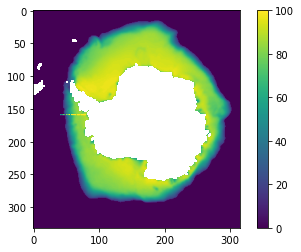

In [131]:
# quick look, why is it at -90°? Why?
plt.imshow(a_masked, vmin=0., vmax=100.)
plt.colorbar()

#### Define another section here, is -90° the prime meridian here?:

In [136]:
NSIDC_lats=np.arange(60.,90.,0.5)  # 60°S to 90°S, in 0.5 steps
NSIDC_lons=-90.*np.ones_like(NSIDC_lats) # section along -90°
hemisphere=-1 # Southern Hemisphere
grid=25 # res is 25km

In [137]:
# find the right pixels
NSIDC_section_idx=nsidc_polar_lonlat(longitude=NSIDC_lons, latitude=NSIDC_lats, grid=grid, hemisphere=hemisphere)
NSIDC_section_idx

[array([ 26,  28,  30,  32,  35,  37,  39,  42,  44,  46,  48,  51,  53,
         55,  58,  60,  62,  64,  67,  69,  71,  73,  75,  78,  80,  82,
         84,  87,  89,  91,  93,  95,  98, 100, 102, 104, 106, 109, 111,
        113, 115, 117, 119, 122, 124, 126, 128, 130, 132, 135, 137, 139,
        141, 143, 145, 148, 150, 152, 154, 156]),
 array([174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174,
        174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174,
        174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174,
        174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174,
        174, 174, 174, 174, 174, 174, 174, 174])]

In [138]:
# keep the sea ice fraction only
a_masked=np.ma.masked_greater(a, 100., copy=True) 
a_masked[tuple(NSIDC_section_idx)]=200

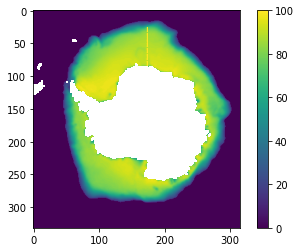

In [139]:
# quick look, why is it shifted to the right, this is not where the prime meridian is
plt.imshow(a_masked, vmin=0., vmax=100.)
plt.colorbar()

In [140]:
#another try, the prime meridian should go through Ross Sea
NSIDC_lats=np.arange(60.,90.,0.5)  # 60°S to 90°S, in 0.5 steps
NSIDC_lons=-270.*np.ones_like(NSIDC_lats) # section along -180°??
hemisphere=-1 # Southern Hemisphere
grid=25 # res is 25km

In [141]:
# find the right pixels
NSIDC_section_idx=nsidc_polar_lonlat(longitude=NSIDC_lons, latitude=NSIDC_lats, grid=grid, hemisphere=hemisphere)
NSIDC_section_idx

[array([291, 289, 287, 285, 282, 280, 278, 275, 273, 271, 269, 266, 264,
        262, 259, 257, 255, 253, 250, 248, 246, 244, 242, 239, 237, 235,
        233, 230, 228, 226, 224, 222, 219, 217, 215, 213, 211, 208, 206,
        204, 202, 200, 198, 195, 193, 191, 189, 187, 185, 182, 180, 178,
        176, 174, 172, 169, 167, 165, 163, 161]),
 array([175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175,
        175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175,
        175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 174,
        174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174,
        174, 174, 174, 174, 174, 174, 174, 174])]

In [142]:
# keep the sea ice fraction only
a_masked=np.ma.masked_greater(a, 100., copy=True) 
a_masked[tuple(NSIDC_section_idx)]=200

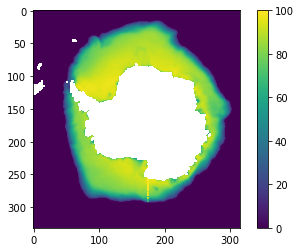

In [143]:
# Yeah, well it does not
plt.imshow(a_masked, vmin=0., vmax=100.)
plt.colorbar()